In [2]:
import pyspark
import numpy as np
from pyspark import SparkContext, SparkConf
from tqdm import tqdm
import pandas as pd

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = np.load('reduced_data.npy')

In [4]:
conf = SparkConf().setAppName("Prova").setMaster("local")
sc = SparkContext(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/08 14:37:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/08 14:37:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
points = list(zip(data[:,0], data[:,1]))
rdd = sc.parallelize(points)
cent = rdd.takeSample(withReplacement=False, num=3) # initial random centroid

22/12/08 14:37:12 WARN TaskSetManager: Stage 0 contains a task of very large size (2231 KiB). The maximum recommended task size is 1000 KiB.


22/12/08 14:37:13 WARN TaskSetManager: Stage 1 contains a task of very large size (2231 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
def min_distance(x, c:list):
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.argmin(dist)

In [18]:
def squared_distance(x, c:list):
    x, c = np.array(x), np.array(c)
    dist = np.array(list(map(lambda a: np.linalg.norm(a - x)**2, c)))
    return np.min(dist)

In [19]:
def k_means(rdd, cent):
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    return pd.DataFrame(belong.collect())
    
def centroids(rdd, cent):
    belong = rdd.map(lambda x: (min_distance(x, cent), x)) # which cluster each data belongs to
    count = belong.countByKey()
    summation = belong.reduceByKey(lambda x, y: (x[0]+y[0],  x[1]+y[1])) # pairwise summation over the values
    cent = summation.map(lambda x: (np.array(x[1])/ count[x[0]]))
    return cent.collect()

def var(rdd, cent):
    accum = sc.accumulator(0)
    rdd.map(lambda x: squared_distance(x, cent)).foreach(lambda x: accum.add(x))
    return accum.value

In [22]:
def iterating(k, rdd, threshold = 10):
    cent = rdd.takeSample(withReplacement=False, num=k) # initial random centroid    
    for i in range(20):
        prev_cent = cent
        cent = centroids(rdd, cent)
        distance = np.linalg.norm(np.array(prev_cent)-np.array(cent))
        if distance < threshold:
            break
    variance = var(rdd, cent)
    clusters = k_means(rdd, cent)
    return clusters, variance

In [24]:
sc.setLogLevel("OFF")
l = []
for k in tqdm(range(3, 11)):
    clusters, variance = iterating(k, rdd, threshold = 10)
    l.append(variance)
print(l)

100%|██████████| 8/8 [20:34<00:00, 154.35s/it]                                  

[2.8013704395767514e+21, 2.1640258634685318e+21, 1.9768303617021276e+21, 1.8701459708189745e+21, 1.8964969868030478e+21, 1.8699815129940964e+21, 1.8548097874513274e+21, 1.8679814308210305e+21]


<AxesSubplot:>

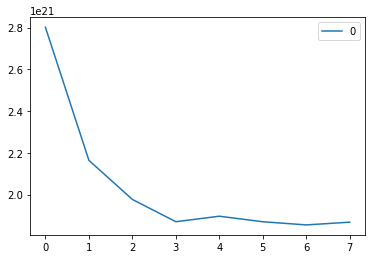

In [25]:
pd.DataFrame(l).plot()